Set up QE

In [1]:
# setup env vars
%env ASE_ESPRESSO_COMMAND=/content/q-e/bin/pw.x -in PREFIX.pwi > PREFIX.pwo
%env ESPRESSO_PSEUDO=/content/q-e/pseudo

env: ASE_ESPRESSO_COMMAND=/content/q-e/bin/pw.x -in PREFIX.pwi > PREFIX.pwo
env: ESPRESSO_PSEUDO=/content/q-e/pseudo


## Calculations on a single-element (`Ta`) slab

> To a first approximation, you can create a BCC slab thick and wide enough so that it has enough "bulk" like material below the surface, enough sites to have a decent representation of the disordered alloy, and wide enough surface area so the deuterium atoms don't interact with their periodic image, but thin enough to limit the calculation to as few atoms as possible. You would want to use the relevant surface plane which most likely is (110) as in other BCC metals. 

env: INPUT_FILENAME=HfNbTaZr_2x2x2.in
env: OUTPUT_FILENAME=HfNbTaZr_2x2x2.out


<Axes: >

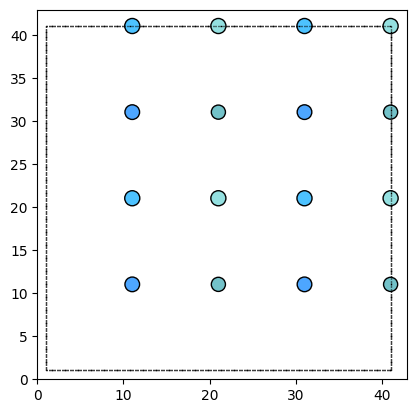

In [14]:
from ase import Atoms
from ase.build import bcc110
from ase.constraints import FixAtoms
from ase.calculators.espresso import Espresso
from ase.units import nm
from ase.io.espresso import write_espresso_in
from ase.visualize import view
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
import nglview
import time
import os

%env INPUT_FILENAME=HfNbTaZr_2x2x2.in
%env OUTPUT_FILENAME=HfNbTaZr_2x2x2.out

d = 20 # made up number
unrelaxed_slab = Atoms(
    'HfNbTaZr',
    positions=[(d/2, 0, 0), (0, d/2, 0), (d/2, d/2, 0), (0, 0, 0)],
    cell=[(0, d, 0), (d, 0, 0), (0, 0, d)]
).repeat((2, 2, 1))
#unrelaxed_slab.rattle(stdev=0.1)

pseudopotentials = {
    'Ta': 'ta_pbe_v1.uspp.F.UPF',
    'Nb': 'nb_pbe_v1.uspp.F.UPF',
    'Hf': 'hf_pbe_v1.uspp.F.UPF',
    'Zr': 'zr_pbe_v1.uspp.F.UPF'
}
input_data = {
    'control': {
        'calculation': 'vc-relax',
        'pseudo_dir': 'q-e/pseudo/',
        'etot_conv_thr': 1e-4,#1e-5,
        'forc_conv_thr': 1e-3,#1e-4,
        'outdir': 'outdir'
    },
    'electrons': {
        'conv_thr': 1e-6#1e-8
    },
    'system': {
        'ecutwfc': 30,
        'occupations': 'smearing', # Need smearing params to avoid `Error in routine electrons (1): charge is wrong: smearing is needed`
        'smearing': 'gaussian',
        'degauss': 0.01
    }
}

# NOTE: kpts = 3 causes failure to converge after 100 iterations; kpts in {1, 4} seems to work?
k = 1
#calc = Espresso(pseudopotentials=pseudopotentials, atoms=unrelaxed_slab, #celldm_1=6.60,
#                tstress=True, tprnfor=True, kpts=(k, k, k), input_data=input_data)
#unrelaxed_slab.calc = calc
with open(os.environ['INPUT_FILENAME'], 'w') as f:
  write_espresso_in(f, unrelaxed_slab, input_data=input_data, pseudopotentials=pseudopotentials, tstress=True, tprnfor=True, kpts=(k, k, k))

# Uncomment this line to view the unrelaxed slab inline
#view(unrelaxed_slab, viewer='x3d')
fig, ax = plt.subplots()
plot_atoms(unrelaxed_slab, ax, radii=0.5, rotation=('0x,0y,180z'))

In [ ]:
!q-e/bin/pw.x -inp $INPUT_FILENAME > $OUTPUT_FILENAME

In [15]:
!mpirun -np 12 q-e/bin/pw.x -inp $INPUT_FILENAME > $OUTPUT_FILENAME

^C


### Calculations on optimized slab
Extract the relaxed slab from our `pwscf` calculation and fix its position. Then insert a deuterium atom and run MD using QE.

In [19]:
from ase import Atom, Atoms
from ase.constraints import FixAtoms
from ase.io.espresso import read_espresso_out, write_espresso_in
from ase.visualize import view
import matplotlib.pyplot as plt
import nglview

with open('ta_cell.out', 'r') as f:
  generator = read_espresso_out(f, index=slice(None))
  atoms = next(generator)

# Center slab in vacuum so there's space for a gas to interact
atoms.center(vacuum=10.0, axis=2)
mask = [atom.z < 3 for atom in atoms]
fixatoms = FixAtoms(mask=mask)
atoms.set_constraint(fixatoms)

# Add unconstrained 2H
DEUTERIUM_MASS_AMU = 2.014
deuterium = Atom('H', mass=DEUTERIUM_MASS_AMU, position=(5., 4., 5.))
atoms.append(deuterium)

# Visualize
view(atoms)

<Popen: returncode: None args: ['/usr/local/google/home/nqc/git/md/venv/bin/...>

In [51]:
from ase.units import Rydberg

# 1 picosecond = n Rydberg a.u.
ps_to_au = 1e-12 / (4.8378 * 1e-17)
ps_to_au

20670.552730580017

In [1]:
pseudopotentials = {
    'Ta': 'ta_pbe_v1.uspp.F.UPF',
    'H': 'h_pbe_v1.4.uspp.F.UPF'
}
input_data = {
    'control': {
        'calculation': 'md',
        'dt': 1 * round(ps_to_au),
        'nstep': 5,
        'pseudo_dir': 'q-e/pseudo/',
        'etot_conv_thr': 1e-5,
        'forc_conv_thr': 1e-4
    },
    'electrons': {
        'conv_thr': 1e-6 # 1e-8
    },
    'system': {
        'ecutwfc': 30,
        'occupations': 'smearing', # Need smearing params to avoid `Error in routine electrons (1): charge is wrong: smearing is needed`
        'smearing': 'gaussian',
        'degauss': 0.01
    },
    'ions': {
        'ion_temperature': 'initial',
        'tempw': 300
    }
}

k = 1
tstress, tprnfor = False, False # True, True
with open('D_Ta_system.in', 'w') as f:
  write_espresso_in(f, atoms, input_data=input_data, pseudopotentials=pseudopotentials, tstress=tstress, tprnfor=tprnfor, kpts=(k, k, k))

SyntaxError: cannot assign to literal here. Maybe you meant '==' instead of '='? (2350401137.py, line 24)

In [47]:
!cat D_Ta_system.in

&CONTROL
   calculation      = 'md'
   nstep            = 5
   tstress          = .false.
   tprnfor          = .false.
   dt               = 20671
   etot_conv_thr    = 1e-05
   forc_conv_thr    = 0.0001
   pseudo_dir       = 'q-e/pseudo/'
/
&SYSTEM
   ecutwfc          = 30
   occupations      = 'smearing'
   degauss          = 0.01
   smearing         = 'gaussian'
   ntyp             = 2
   nat              = 19
   ibrav            = 0
/
&ELECTRONS
   conv_thr         = 1e-06
/
&IONS
/
&CELL
/

ATOMIC_SPECIES
Ta 180.94788 ta_pbe_v1.uspp.F.UPF
H 2.014 h_pbe_v1.4.uspp.F.UPF

K_POINTS automatic
1 1 1  0 0 0

CELL_PARAMETERS angstrom
9.91740002187914 0.00000000000000 0.00000000000000
4.95870001093957 7.01266297727089 0.00000000000000
0.00000000000000 0.00000000000000 22.33755300343696

ATOMIC_POSITIONS angstrom
Ta 0.0000000000 2.3375539952 10.0000000000 
Ta 3.3057996767 2.3375539952 10.0000000000 
Ta 6.6116003452 2.3375539952 10.0000000000 
Ta 1.6529003342 4.6751069986 10.0000000000 
Ta 

Inside an image, PW and k-point parallelization can be performed: for instance,

   `mpirun -np 64 ph.x -ni 8 -nk 2 ...`
will run 8 images on 8 processors each, subdivided into 2 pools of 4 processors for k-point parallelization. In order to run the ph.x code with these flags the pw.x run has to be run with:
   `mpirun -np 8 pw.x -nk 2 ...`
without any `-nimage` flag. 

In [49]:
start_time = time.time()
!mpirun -np 12 q-e/bin/pw.x -inp D_Ta_system.in > D_Ta_system.out
end_time = time.time()
print(end_time, start_time, end_time - start_time)

STOP 2
STOP 2
STOP 2
STOP 2
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
STOP 2
STOP 2
STOP 2
STOP 2
STOP 2
STOP 2
STOP 2
--------------------------------------------------------------------------
Primary job  terminated normally, but 1 process returned
a non-zero exit code. Per user-direction, the job has been aborted.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
mpirun detected that one or more processes exited with non-zero status, thus causing
the job to be terminated. The first process to do so was:

  Process name: [[9964,1],5]
  Exit code:    2
--------------------------------------------------------------------------
1683225712.9510887 1683223940.7247276 1772.2263610363007


In [2]:
!cat D_Ta_system.out


     Program PWSCF v.7.2 starts on  4May2023 at 18:12:20 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Parallel version (MPI), running on    12 processors

     MPI processes distributed on     1 nodes
     69356 MiB available memory on the printing compute node when the environment starts

     Reading input from D_Ta_system.in

     Current dimensions of program PWSCF are:
     Max number of different atomic species (ntypx) = 10
     Max number of k-points (npk) =  40000
     Max angular momentum in pseudopotentials (lmaxx) 

## Visualizing `nstep=5` trajectory

In [22]:
from ase.io.espresso import read_espresso_out
from ase.visualize import view
import matplotlib.pyplot as plt
import nglview

with open('D_Ta_system.out', 'r') as f:
    generator = read_espresso_out(f, index=slice(None))
    atoms = next(generator)

In [23]:
view(atoms)

<Popen: returncode: None args: ['/usr/local/google/home/nqc/git/md/venv/bin/...>

view(next(generator))